In [1]:
import numpy as np
import os
import random
import torch 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from TransUNet.networks.vit_seg_modeling import VisionTransformer
from TransUNet.networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
from dataset_function import *
from loss_functions import *
from model_training_function import *
from model_inference_function import *

In [2]:
# this function guarantees reproductivity
def seed_everything(TORCH_SEED):
	random.seed(TORCH_SEED)
	os.environ['PYTHONHASHSEED'] = str(TORCH_SEED)
	np.random.seed(TORCH_SEED)
	torch.manual_seed(TORCH_SEED)
	torch.cuda.manual_seed_all(TORCH_SEED)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

In [3]:
seed = 1126
seed_everything(seed)

### Data Preprocessing

In [4]:
# Function to set the seed for each worker
def seed_worker(worker_id):
    # Set seed for Python and NumPy in each worker
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [5]:
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
cases = os.listdir('./tcia_dataset_preprocessed/')
cases_idx = np.arange(len(cases))

In [7]:
train_cases, val_cases, test_cases = split_data_tcia(cases, cases_idx)

In [8]:
print(len(train_cases))
print(len(val_cases))
print(len(test_cases))

52
7
16


In [9]:
train_dataset = TCIADataset(train_cases, training = True, use_joint_transforms = True)
validation_dataset = TCIADataset(val_cases, training = False, use_joint_transforms = True)
testing_dataset = TCIADataset(test_cases, training = False, use_joint_transforms = False)

In [10]:
print(f'train size: {len(train_dataset)}')
print(f'valid size: {len(validation_dataset)}')
print(f'test size: {len(testing_dataset)}')

train size: 3495
valid size: 452
test size: 968


In [11]:
g_train = torch.Generator()
g_train.manual_seed(seed)
g_val = torch.Generator()
g_val.manual_seed(seed + 1)
g_test = torch.Generator()
g_test.manual_seed(seed + 2)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, generator = g_train, worker_init_fn = seed_worker)
validation_loader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = False, generator = g_val, worker_init_fn = seed_worker)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle = False, generator = g_test, worker_init_fn = seed_worker)

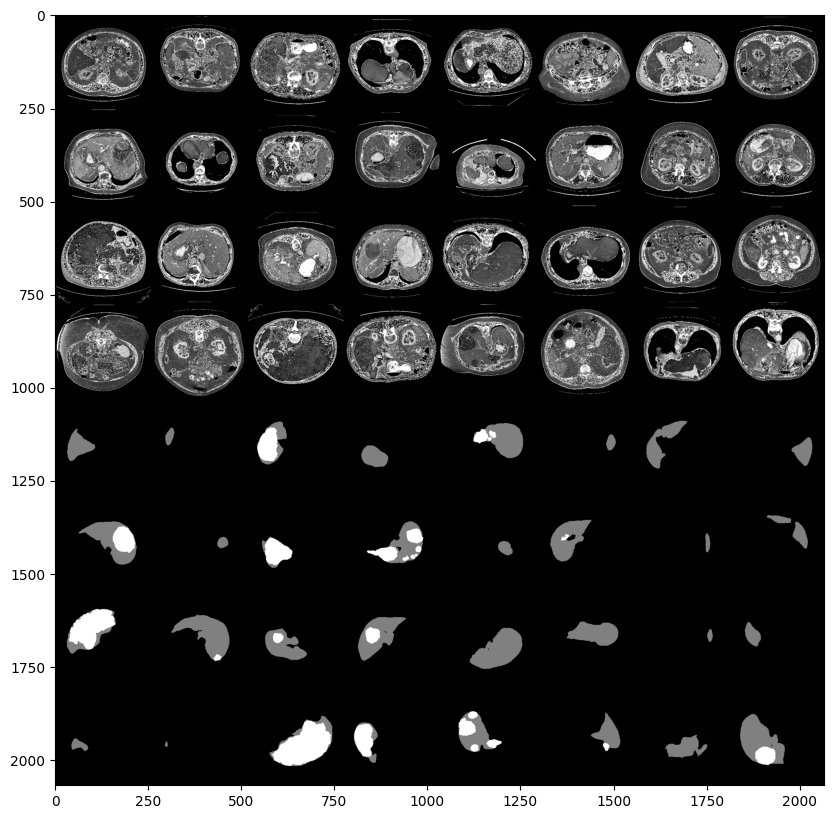

In [12]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
images = images * 255
images = images.to(torch.uint8)
labels = labels.apply_(label_mapping.get)
labels = torch.stack((labels, labels, labels), dim = 1)

grid_img = make_grid(images)
grid_label = make_grid(labels)
concat = torch.cat((grid_img, grid_label), dim = 1)

plt.figure(figsize = (10, 10))
plt.imshow(concat.permute(1, 2, 0))
plt.show()

### Model Training

In [13]:
config_vit = CONFIGS_ViT_seg["R50-ViT-B_16"]
config_vit.n_classes = 3
config_vit.n_skip = 3
model = VisionTransformer(config_vit, img_size = 256, num_classes = config_vit.n_classes).to(device)
weight = np.load('./TransUNet/R50+ViT-B_16.npz')
model.load_from(weights = weight)

load_pretrained: grid-size from 14 to 16


In [14]:
LR = 0.001
num_epochs = 100
patience = 20
weight_decay = 1e-4
class_weights = [0.1, 1.0, 2.0]

In [15]:
criterion = WeightedCombinedLoss(class_weights = class_weights)
optimizer = optim.Adam(model.parameters(), lr = LR, weight_decay = weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.5)

In [16]:
writer = SummaryWriter('runs/transunet_weighted')
writer.add_scalar('Loss/train', 10, 0)
writer.add_scalar('Dice_1/train', 0, 0)
writer.add_scalar('Dice_2/train', 0, 0)
writer.add_scalar('Loss/valid', 10, 0)
writer.add_scalar('Dice_1/valid', 0, 0)
writer.add_scalar('Dice_2/valid', 0, 0)

In [17]:
train_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, writer, num_epochs, patience = patience, save_dir = './model_storage/transunet_weighted', class_weights = class_weights)

Epoch 1/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.8760, Train Dice1: 0.4727, Train Dice2: 0.4257
Validation Loss: 0.8105, Validation Dice1: 0.5008, Validation Dice2: 0.1384
Best model saved!


Epoch 2/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.6910, Train Dice1: 0.5951, Train Dice2: 0.4122
Validation Loss: 0.7126, Validation Dice1: 0.5630, Validation Dice2: 0.2540
Best model saved!


Epoch 3/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.6372, Train Dice1: 0.6472, Train Dice2: 0.4521
Validation Loss: 0.8405, Validation Dice1: 0.4967, Validation Dice2: 0.5409
Best model saved!


Epoch 4/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.6028, Train Dice1: 0.6842, Train Dice2: 0.4728
Validation Loss: 0.7412, Validation Dice1: 0.5978, Validation Dice2: 0.6274
Best model saved!


Epoch 5/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.5928, Train Dice1: 0.6921, Train Dice2: 0.5066
Validation Loss: 0.6856, Validation Dice1: 0.5855, Validation Dice2: 0.4305


Epoch 6/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.5839, Train Dice1: 0.7035, Train Dice2: 0.5211
Validation Loss: 0.7472, Validation Dice1: 0.5428, Validation Dice2: 0.1930


Epoch 7/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 0.5730, Train Dice1: 0.7161, Train Dice2: 0.5536
Validation Loss: 2.2667, Validation Dice1: 0.0120, Validation Dice2: 0.5975


Epoch 8/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 0.5945, Train Dice1: 0.6871, Train Dice2: 0.5054
Validation Loss: 0.7128, Validation Dice1: 0.5816, Validation Dice2: 0.4673


Epoch 9/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 0.5544, Train Dice1: 0.7325, Train Dice2: 0.5869
Validation Loss: 0.7495, Validation Dice1: 0.5717, Validation Dice2: 0.3355


Epoch 10/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 0.5558, Train Dice1: 0.7294, Train Dice2: 0.5786
Validation Loss: 0.5683, Validation Dice1: 0.6911, Validation Dice2: 0.4208


Epoch 11/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 0.5391, Train Dice1: 0.7433, Train Dice2: 0.6050
Validation Loss: 0.8024, Validation Dice1: 0.6159, Validation Dice2: 0.7114
Best model saved!


Epoch 12/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 0.5307, Train Dice1: 0.7569, Train Dice2: 0.6350
Validation Loss: 0.6206, Validation Dice1: 0.6672, Validation Dice2: 0.3542


Epoch 13/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 0.5228, Train Dice1: 0.7629, Train Dice2: 0.6284
Validation Loss: 1.5519, Validation Dice1: 0.3127, Validation Dice2: 0.5896


Epoch 14/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 0.5312, Train Dice1: 0.7509, Train Dice2: 0.6097
Validation Loss: 0.7451, Validation Dice1: 0.6729, Validation Dice2: 0.6307


Epoch 15/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 0.5217, Train Dice1: 0.7589, Train Dice2: 0.6022
Validation Loss: 0.8732, Validation Dice1: 0.5090, Validation Dice2: 0.5654


Epoch 16/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 0.5095, Train Dice1: 0.7780, Train Dice2: 0.6428
Validation Loss: 0.6259, Validation Dice1: 0.6515, Validation Dice2: 0.3149


Epoch 17/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 0.5004, Train Dice1: 0.7791, Train Dice2: 0.6531
Validation Loss: 0.6057, Validation Dice1: 0.6863, Validation Dice2: 0.5609


Epoch 18/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 0.4911, Train Dice1: 0.7912, Train Dice2: 0.6664
Validation Loss: 0.8639, Validation Dice1: 0.6164, Validation Dice2: 0.5811


Epoch 19/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 0.4884, Train Dice1: 0.7947, Train Dice2: 0.6660
Validation Loss: 0.5995, Validation Dice1: 0.6449, Validation Dice2: 0.3178


Epoch 20/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 0.4815, Train Dice1: 0.8005, Train Dice2: 0.6709
Validation Loss: 0.6181, Validation Dice1: 0.6481, Validation Dice2: 0.5396


Epoch 21/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 0.4537, Train Dice1: 0.8220, Train Dice2: 0.7336
Validation Loss: 0.5685, Validation Dice1: 0.7440, Validation Dice2: 0.6277


Epoch 22/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [22/100], Train Loss: 0.4470, Train Dice1: 0.8252, Train Dice2: 0.7450
Validation Loss: 0.6343, Validation Dice1: 0.7341, Validation Dice2: 0.6482


Epoch 23/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [23/100], Train Loss: 0.4475, Train Dice1: 0.8281, Train Dice2: 0.7324
Validation Loss: 0.5498, Validation Dice1: 0.7477, Validation Dice2: 0.6264


Epoch 24/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [24/100], Train Loss: 0.4417, Train Dice1: 0.8345, Train Dice2: 0.7521
Validation Loss: 0.6152, Validation Dice1: 0.7023, Validation Dice2: 0.5935


Epoch 25/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [25/100], Train Loss: 0.4372, Train Dice1: 0.8357, Train Dice2: 0.7644
Validation Loss: 0.5698, Validation Dice1: 0.7470, Validation Dice2: 0.5108


Epoch 26/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [26/100], Train Loss: 0.4375, Train Dice1: 0.8363, Train Dice2: 0.7430
Validation Loss: 0.6039, Validation Dice1: 0.6826, Validation Dice2: 0.4395


Epoch 27/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [27/100], Train Loss: 0.4515, Train Dice1: 0.8216, Train Dice2: 0.7207
Validation Loss: 0.6557, Validation Dice1: 0.6933, Validation Dice2: 0.6326


Epoch 28/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [28/100], Train Loss: 0.4331, Train Dice1: 0.8373, Train Dice2: 0.7469
Validation Loss: 0.5920, Validation Dice1: 0.7440, Validation Dice2: 0.6820
Best model saved!


Epoch 29/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [29/100], Train Loss: 0.4291, Train Dice1: 0.8427, Train Dice2: 0.7615
Validation Loss: 0.5588, Validation Dice1: 0.7382, Validation Dice2: 0.5506


Epoch 30/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [30/100], Train Loss: 0.4295, Train Dice1: 0.8440, Train Dice2: 0.7573
Validation Loss: 0.5592, Validation Dice1: 0.7041, Validation Dice2: 0.4042


Epoch 31/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [31/100], Train Loss: 0.4247, Train Dice1: 0.8499, Train Dice2: 0.7728
Validation Loss: 0.5347, Validation Dice1: 0.7544, Validation Dice2: 0.6074


Epoch 32/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [32/100], Train Loss: 0.4212, Train Dice1: 0.8488, Train Dice2: 0.7746
Validation Loss: 0.6805, Validation Dice1: 0.6713, Validation Dice2: 0.5610


Epoch 33/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [33/100], Train Loss: 0.4164, Train Dice1: 0.8514, Train Dice2: 0.7815
Validation Loss: 0.5781, Validation Dice1: 0.7209, Validation Dice2: 0.4979


Epoch 34/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [34/100], Train Loss: 0.4208, Train Dice1: 0.8500, Train Dice2: 0.7668
Validation Loss: 0.5484, Validation Dice1: 0.7306, Validation Dice2: 0.4984


Epoch 35/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [35/100], Train Loss: 0.4219, Train Dice1: 0.8456, Train Dice2: 0.7693
Validation Loss: 0.6084, Validation Dice1: 0.7287, Validation Dice2: 0.5579


Epoch 36/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [36/100], Train Loss: 0.4136, Train Dice1: 0.8549, Train Dice2: 0.7852
Validation Loss: 0.5797, Validation Dice1: 0.7352, Validation Dice2: 0.5020


Epoch 37/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [37/100], Train Loss: 0.4159, Train Dice1: 0.8520, Train Dice2: 0.7850
Validation Loss: 0.6663, Validation Dice1: 0.7181, Validation Dice2: 0.5553


Epoch 38/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [38/100], Train Loss: 0.4209, Train Dice1: 0.8428, Train Dice2: 0.7683
Validation Loss: 0.6737, Validation Dice1: 0.6225, Validation Dice2: 0.2987


Epoch 39/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [39/100], Train Loss: 0.4266, Train Dice1: 0.8448, Train Dice2: 0.7592
Validation Loss: 0.5450, Validation Dice1: 0.7298, Validation Dice2: 0.5701


Epoch 40/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [40/100], Train Loss: 0.4072, Train Dice1: 0.8599, Train Dice2: 0.7955
Validation Loss: 0.5399, Validation Dice1: 0.7346, Validation Dice2: 0.5567


Epoch 41/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [41/100], Train Loss: 0.3933, Train Dice1: 0.8707, Train Dice2: 0.8141
Validation Loss: 0.5595, Validation Dice1: 0.7613, Validation Dice2: 0.5625


Epoch 42/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [42/100], Train Loss: 0.3874, Train Dice1: 0.8750, Train Dice2: 0.8388
Validation Loss: 0.5661, Validation Dice1: 0.7324, Validation Dice2: 0.5443


Epoch 43/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [43/100], Train Loss: 0.3847, Train Dice1: 0.8776, Train Dice2: 0.8334
Validation Loss: 0.5946, Validation Dice1: 0.7453, Validation Dice2: 0.6251


Epoch 44/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [44/100], Train Loss: 0.3843, Train Dice1: 0.8799, Train Dice2: 0.8484
Validation Loss: 0.5924, Validation Dice1: 0.7429, Validation Dice2: 0.5645


Epoch 45/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [45/100], Train Loss: 0.3801, Train Dice1: 0.8816, Train Dice2: 0.8454
Validation Loss: 0.6111, Validation Dice1: 0.7468, Validation Dice2: 0.4660


Epoch 46/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [46/100], Train Loss: 0.3788, Train Dice1: 0.8839, Train Dice2: 0.8401
Validation Loss: 0.5598, Validation Dice1: 0.7266, Validation Dice2: 0.3940


Epoch 47/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [47/100], Train Loss: 0.3911, Train Dice1: 0.8718, Train Dice2: 0.7950
Validation Loss: 0.6406, Validation Dice1: 0.7398, Validation Dice2: 0.5808


Epoch 48/100:   0%|          | 0/110 [00:00<?, ?batch/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [48/100], Train Loss: 0.3779, Train Dice1: 0.8838, Train Dice2: 0.8523
Validation Loss: 0.6120, Validation Dice1: 0.7413, Validation Dice2: 0.6070
Early Stop at 48!


In [18]:
config_vit = CONFIGS_ViT_seg["R50-ViT-B_16"]
config_vit.n_classes = 3
config_vit.n_skip = 3
best_model = VisionTransformer(config_vit, img_size = 256, num_classes = config_vit.n_classes).to(device)
checkpoint = torch.load('./model_storage/transunet_weighted/best.pth')
best_model.load_state_dict(checkpoint)
criterion = WeightedCombinedLoss(class_weights = class_weights)

In [19]:
train_dice_1, train_dice_2, train_iou_1, train_iou_2 = test_model(best_model, train_loader, criterion)

  0%|          | 0/110 [00:00<?, ?it/s]

Loss: 0.4334, Dice1: 0.8532, Dice2: 0.8379, IoU1: 0.7819, IoU2: 0.7975


In [20]:
test_dice_1, test_dice_2, test_iou_1, test_iou_2 = test_model(best_model, testing_loader, criterion)

  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.5788, Dice1: 0.7215, Dice2: 0.7758, IoU1: 0.6242, IoU2: 0.7298


In [21]:
idx = random.randint(0, len(testing_dataset))
selected_img, selected_label = testing_dataset[idx]

In [22]:
pred = infernece(best_model, selected_img)

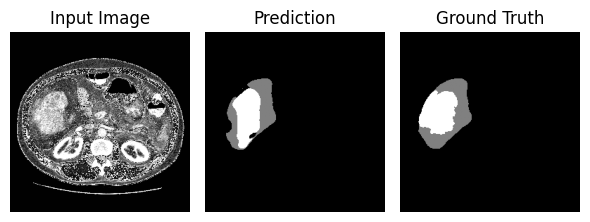

In [23]:
display_result(selected_img, pred, selected_label)